In [1]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import zipfile
# # Define the path to the zip file
# file_path = '/content/drive/MyDrive/KaggleDatasets/food image.zip'

# # Unzip the file to a specific destination
# with zipfile.ZipFile(file_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/KaggleDatasets\FoodImage')  # Folder name where to extract the zip file

In [4]:
os.chdir('/content/drive/MyDrive/KaggleDatasets/FoodImage')
!ls

data  evaluation  training  validation


In [5]:
!ls training

food  non_food


In [6]:
# Make directories to store data in Keras Style
# !mkdir data

In [7]:
# !mkdir data/train
# !mkdir data/test
# !mkdir data/train/food
# !mkdir data/train/nonfood
# !mkdir data/test/food
# !mkdir data/test/nonfood


In [8]:
# Move the images from original downloaded data to directory folders
# Training to be training set, test data to be testing set, ignoring evaluation set

# !mv training/nonfood/0*.jpg data/train/nonfood
# !mv training/food/1*.jpg data/train/food
# !mv validation/nonfood/0*.jpg data/test/nonfood
# !mv validation/food/1*.jpg data/test/food


In [9]:
train_path= '/content/drive/MyDrive/KaggleDatasets/FoodImage/training'
valid_path= '/content/drive/MyDrive/KaggleDatasets/FoodImage/validation'

In [10]:
Image_size = [200, 200]

In [11]:
# useful for getting list of image files using glob function

image_files= glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [ ]:
# useful for getting number of classes

folders = glob(train_path +'/*')
folders

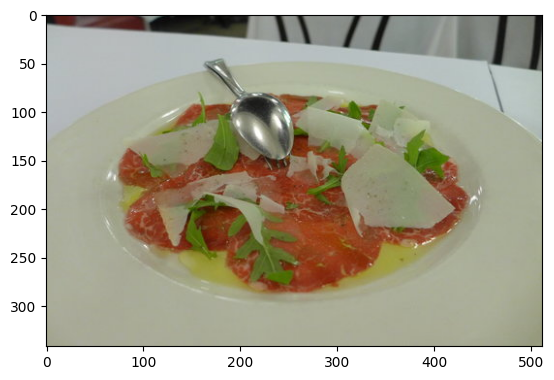

In [13]:
# lets look at an image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

### Pretrained Model to train the Image Files

In [ ]:
# Image_size - Dimension of image files ; [3] - rgb color channels
# weights: The model downloads pretrained weights from VGG trained on imagenet dataset
# otherwise weights will be placed randomly, then we would have to train them
# include_top = False : Instead of getting full network layer, we just get all the layers upto the final conv layer. Flatten and dense layer will not be rendered

ptm = PretrainedModel(
    input_shape= Image_size + [3],
    weights = 'imagenet',
    include_top = False
)

In [15]:
# freeze pretrained model weights
# when we call model.fit later, these weights will not be changed by gradient descent

ptm.trianable = False

In [16]:
# Map the data into feature vectors

# number of classes
K = len(folders)
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [17]:
# create a model object

model = Model(inputs = ptm.input, outputs =x)

In [18]:
model.summary()

# In Keras, non-trainable parameters are the ones that are not trained using gradient descent. This is also controlled by the trainable parameter in each layer
# For deciding whether weights are trainable or not, you take layers from the model and set trainable:
# model.get_layer(layerName).trainable = False #or True

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

## Data Augmentation for Training and Validation Data

In [19]:
# Create an instance of ImageDataGenerator
# For Data Augmentation

gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)
# preprocess_input: The generator will transform the images into an appropriate format for VGG network

In [20]:
batch_size = 128

#  create generator
train_generator = gen.flow_from_directory(
    train_path,
    shuffle = True,
    target_size = Image_size,
    batch_size = batch_size,
)
valid_generator = gen.flow_from_directory(
    valid_path,
    shuffle = True,
    target_size = Image_size,
    batch_size = batch_size,
)

Found 2389 images belonging to 2 classes.
Found 889 images belonging to 2 classes.


## Compilation

In [21]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)
# categorical crossentropy becoz the generator generates the targets as one hot encoded metrices

In [ ]:
# fit the model

# train_generator : Generates training data for validation data
# train stepes per epoch ; validation steps per epoch
r = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    steps_per_epoch = int(np.ceil(len(image_files) / batch_size)),
    validation_steps = int(np.ceil(len(image_files) / batch_size))
)

In [ ]:
# loss

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.hisotry['val_accuracy'], label='val acc')
plt.legend()
plt.show()